# 6. Naive Bayes

The purpose of this notebook is to generate naive bayes model for the climate data and headliens. This will provide further insight into the way that the data may be semantically paritioned.

---

## 1. Environment Creation

### 1.1 Library Import

In [393]:
''' DATA MANAGEMENT ''' 
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import ast
from collections import Counter
import regex as re

''' VECTORIZATION '''
from sklearn.feature_extraction.text import CountVectorizer

''' DATA VISUALIZATION '''
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from tabulate import tabulate
import numpy as np


''' SANITY '''
from tqdm import tqdm


''' MODEL VERIFICATION  '''
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


''' NAIVE BAYES'''
from sklearn.naive_bayes import MultinomialNB

### 1.2 Function Definition

In [76]:
def train_test_splitter(data, label_column):
    
    data_train, data_test = train_test_split(data, test_size = 0.3,)
    labels_train = data_train[label_column]
    labels_test = data_test[label_column]
    
    #data_train.drop(columns='LABEL', inplace=True)
    #data_test.drop(columns='LABEL', inplace=True)
    
    
    return (data_train, data_test, labels_train, labels_test)

In [364]:

def visual_confusion_matrix(data,labels, predictions ,title, label_name, file_name, fig_x, fig_y):
    
    _labels = sorted(set(labels).union(set(predictions)))

    confusion_df = pd.DataFrame(data, index=_labels, columns=_labels)

    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
        
    
    sb.heatmap(confusion_df, annot = True, fmt='d', xticklabels=_labels, yticklabels=_labels, cbar_kws={'shrink': 0.5}, ax=ax)
    ax.set_title(f"Confusion Matrix:\n{title}\nLabels: {label_name}")
    ax.set_ylabel("True Labels")
    ax.set_xlabel("Predicted Labels")
    
    ax.set_aspect('equal', adjustable='box')
    #plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)
    
    # Save and show the plot
    
    plt.tight_layout(pad=.5)
    plt.savefig(file_name, dpi=600)
    
    plt.show()

In [147]:
def model_verification(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division = 0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division = 0)
    
    return accuracy, precision, recall

In [354]:
## MNB Modeler:
def mnb_modeler(data_train, labels_train, data_test, labels_test, label_column_name,  graph_title, labels_name, file_name,filter_top_n = False, N=10 ,fig_x = 6, fig_y = 4):
    data_train = data_train.drop(columns = label_column_name).copy()
    data_test = data_test.drop(columns = label_column_name).copy()
    
    mnb_model = MultinomialNB()

    ## Fitting the data
    mnb_full = mnb_model.fit(data_train, labels_train)
    
    ## Creating predictions
    predictions = mnb_full.predict(data_test)
    
    ## Assessing the models abilitiy
    accuracy, precision, recall = model_verification(labels_test, predictions)
    
    ## Filtering for Clean Visualizations
    if filter_top_n == True:
        labels_test, predictions = filter_top_n_labels(labels_test, predictions, N)

    ## Generating a confusion matrix
    
    matrix_ = confusion_matrix(labels_test, predictions)
    visual_confusion_matrix(matrix_, labels_test, predictions, graph_title, labels_name, file_name, fig_x, fig_y)
    
    return (accuracy, precision, recall)

In [219]:
def filter_top_n_labels(labels, predictions, N):
    top_labels = [label for label, _ in Counter(labels).most_common(N)]
    mask = [(yt in top_labels and yp in top_labels) for yt, yp in zip(labels, predictions)]
    labels_filtered = [yt for yt, m in zip(labels, mask) if m]
    predictions_filtered = [yp for yp, m in zip(predictions, mask) if m]
    return labels_filtered, predictions_filtered


### 1.3 Data Import

In [236]:
news_data = pd.read_csv(r"C:\Users\natal\OneDrive\university\info 5653\data\News Articles Lemmed- Count Vectorizer.csv")
news_data.fillna(0,inplace=True)
news_data.drop(columns='Unnamed: 0', inplace = True)

non_zero_condition = news_data['Party'] != 0
news_data = news_data[non_zero_condition]

In [237]:
bills_data = pd.read_csv(r"C:\Users\natal\OneDrive\university\info 5653\data\Bills Lemmed- Count Vectorizer.csv")
bills_data.fillna(0,inplace=True)
bills_data.drop(columns='Unnamed: 0', inplace = True)

non_zero_condition = bills_data['Committees'] != 0
bills_data = bills_data[non_zero_condition]

In [238]:
party_data = pd.read_csv(r"C:\Users\natal\OneDrive\university\info 5653\data\Party Platform Lemmed- Count Vectorizer.csv")
party_data.drop(columns='Unnamed: 0', inplace = True)

In [239]:
''' REVECTORIZING DATA '''

## Recreate CountVectorizer with the original vocabulary
vectorizer_news = CountVectorizer(vocabulary=news_data.columns)
vectorizer_bills = CountVectorizer(vocabulary=bills_data.columns)
vectorizer_party = CountVectorizer(vocabulary=party_data.columns)


In [240]:
''' PULLING OUT THE FEATURE NAMES '''
features_news = news_data.columns.to_list()
features_bills = bills_data.columns.to_list()
features_party = party_data.columns.to_list()

In [241]:
''' CREATING A COMBINED LABEL COLUMN FOR MORE LABEL INFORMATINO IN SKLEARN '''

news_data.insert(0, 'LABEL', news_data['Party'].astype(str).fillna('') + ' | ' + news_data['publisher'].astype(str).fillna(''))

## note: the committee was not added to this because of the diversity and length  of the committee
## - so the purpose of this column is more in order to generate a nunance about sponser state, affiliation,
## and bill type
bills_data.insert(0, 'LABEL', bills_data['Bill Type'].astype(str).fillna('') + ' | ' + bills_data['Sponser Affiliation'].astype(str).fillna('') +' | ' + bills_data['Sponser State'].astype(str).fillna(''))

In [242]:
''' STORING THE LABELS '''

## News Data
labels_news_party = news_data['Party'].to_list()
labels_news_publisher = news_data['publisher'].to_list()
labels_news_combined = news_data['LABEL'].to_list()

## Bill Data
labels_bills_billtype = bills_data['Bill Type']
labels_bills_sponser_affiliation = bills_data['Sponser Affiliation']
labels_bills_sponser_state = bills_data['Sponser State']
labels_bills_committees = bills_data['Committees']
labels_bills_combined = bills_data['LABEL'].to_list()

## Party Platform Data
labels_party_party = party_data['Party']

In [243]:
news_data.head(2)

,LABEL,Party,publisher,aapi,abandon,abandoned,abc,ability,able,abolish,...,yes,york,young,youth,zealot,zeldin,zero,zers,zone,zuckerberg
0,Republican | The Verge,Republican,The Verge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Republican | Gizmodo.com,Republican,Gizmodo.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [244]:
bills_data.head(2)

,LABEL,Bill Type,Sponser Affiliation,Sponser State,Committees,aa,aaa,aarhu,ab,abandon,...,zoe,zone,zonea,zonesnotwithstand,zoneth,zoo,zoolog,zoonot,zooplankton,zquez
0,hr | D | HI,hr,D,HI,"House - Natural Resources, Agriculture | Senat...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hr | R | NY,hr,R,NY,House - Agriculture,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [245]:
party_data.head()

,Party,ability,able,abortion,access,accessible,according,accountability,accountable,achieved,...,won,word,work,worker,working,world,worship,worst,year,young
0,Republican,1,1,1,4,1,1,1,4,1,...,1,1,4,15,2,15,2,1,7,7
1,Democrat,7,13,13,72,15,1,6,14,1,...,10,1,101,79,81,69,4,4,149,10


## 2. Data Preparation

### 2.1 Generating a Train Test Split for The Data


#### 2.1.2 News Data

In [246]:
## Creating individually labeled sets for the data

news_data_label_party = news_data.drop(columns = ['publisher', 'LABEL'])
data_train_news_party, data_test_news_party, labels_train_news_party, labels_test_news_party = train_test_splitter(news_data_label_party,'Party')

news_data_label_publisher = news_data.drop(columns = ['Party', 'LABEL'])
data_train_news_publisher, data_test_news_publisher, labels_train_news_publisher, labels_test_news_publisher = train_test_splitter(news_data_label_publisher,'publisher')

news_data_label_combined = news_data.drop(columns = ['Party', 'publisher'])
data_train_news_combined, data_test_news_combined, labels_train_news_combined, labels_test_news_combinedr = train_test_splitter(news_data_label_combined,'LABEL')


In [247]:
bills_data_label_party = bills_data.drop(columns = ['LABEL', 'Bill Type', 'Sponser State', 'Committees'])
data_train_bills_party, data_test_bills_party, labels_train_bills_party, labels_test_bills_party = train_test_splitter(bills_data_label_party,'Sponser Affiliation')


bills_data_label_state = bills_data.drop(columns = ['LABEL', 'Bill Type', 'Sponser Affiliation', 'Committees'])
data_train_bills_state, data_test_bills_state, labels_train_bills_state, labels_test_bills_state = train_test_splitter(bills_data_label_state,'Sponser State')


bills_data_label_combined = bills_data.drop(columns = ['Sponser State', 'Bill Type', 'Sponser Affiliation', 'Committees'])
data_train_bills_combined, data_test_bills_combined, labels_train_bills_combined, labels_test_bills_combined = train_test_splitter(bills_data_label_combined,'LABEL')

bills_data_label_type = bills_data.drop(columns = ['LABEL', 'Sponser State', 'Sponser Affiliation', 'Committees'])
data_train_bills_type, data_test_bills_type, labels_train_bills_type, labels_test_bills_type = train_test_splitter(bills_data_label_type,'Bill Type')

bills_data_label_committee = bills_data.drop(columns = ['LABEL', 'Bill Type', 'Sponser Affiliation', 'Sponser State'])
data_train_bills_committee, data_test_bills_committee, labels_train_bills_committee, labels_test_bills_committee = train_test_splitter(bills_data_label_committee,'Committees')



In [414]:
length_data = [['News Headline: Partisian Affiliation',len(data_train_news_party), len(data_test_news_party)],
['News Headlines: Publisher',len(data_train_news_publisher), len(data_test_news_publisher)], 
['News Headlines: Publisher and Partisian Affiliation',len(data_train_news_combined), len(data_test_news_combined)], 
['Climate Bills: Sponsor Affiliation',len(data_train_bills_party), len(data_test_bills_party)], 
['Climate Bills: Sponsor State',len(data_train_bills_state), len(data_test_bills_state)], 
['Climate Bills: Metadata',len(data_train_bills_combined), len(data_test_bills_combined)], 
['Climate Bills: Bill Type',len(data_train_bills_type), len(data_test_bills_type)], 
['Climate Bills: Hearing Committee',len(data_train_bills_committee), len(data_test_bills_committee)]]

headers = ['', ' Training Data', 'Testing Data']

length_table = tabulate(length_data, headers=headers, tablefmt='html', numalign='center', stralign = 'left')

with open("Train Test Split Lengths.html", "w") as file:
    file.write(length_table)
    
length_table

,Training Data,Testing Data
News Headline: Partisian Affiliation,573,246
News Headlines: Publisher,573,246
News Headlines: Publisher and Partisian Affiliation,573,246
Climate Bills: Sponsor Affiliation,2256,967
Climate Bills: Sponsor State,2256,967
Climate Bills: Metadata,2256,967
Climate Bills: Bill Type,2256,967
Climate Bills: Hearing Committee,2256,967


## 3. Training the Multinomial Naive Bayes Models

``` python
## MNB Modeler:
def mnb_modeler(data_train, labels_train, data_test, labels_test, graph_title, labels_name, file_name):
    mnb_model = MultinomialNB()

    ## Fitting the data
    mnb_full = mnb_model.fit(data_train, labels_train)
    
    ## Creating predictions
    predictions = mnb_full.predict(data_test)
    
    ## Assessing the models abilitiy
    accuracy, precision, recall = model_verification(labels_test, predictions)
    
    ## Generating a confusion matrix
    confusion_matrix = confusion_matrix(labels_test, predictions)
    visual_confusion_matrix(confusion_matrix, labels_test, graph_title, labels_name)
    
    return (accuracy, precision, recall)
```

### 3.1 News Data

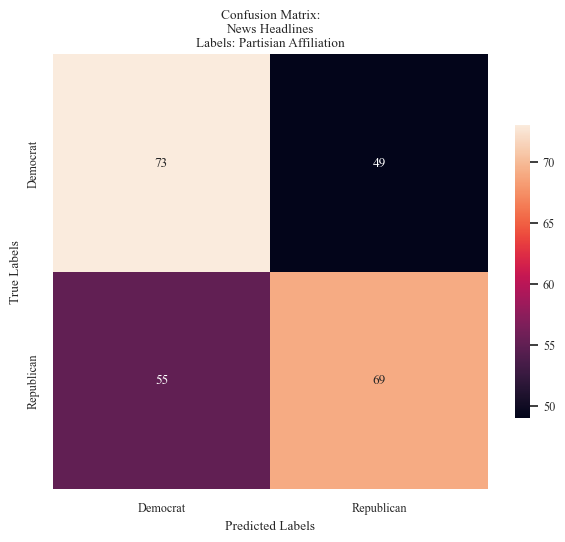

In [370]:
accuracy_news_data_party, precision_news_data_party, recall_news_data_party = mnb_modeler(data_train_news_party, labels_train_news_party,
                                                                                         data_test_news_party, labels_test_news_party,
                                                                                          'Party',
                                                                                         'News Headlines',
                                                                                         'Partisian Affiliation', 'mnb cm - news partisian affiliation.png',
                                                                                         False, 10,fig_x = 6, fig_y = 6)

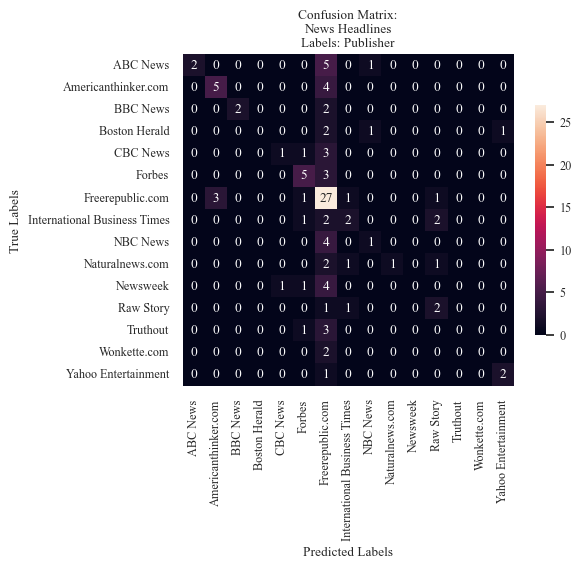

In [369]:
accuracy_news_data_publisher, precision_news_data_publisher, recall_news_data_publisher = mnb_modeler(data_train_news_publisher, labels_train_news_publisher,
                                                                                         data_test_news_publisher, labels_test_news_publisher,
                                                                                          'publisher',
                                                                                         'News Headlines',
                                                                                         'Publisher', 'mnb cm - news publisher.png',
                                                                                                  True ,15 ,  fig_x = 6, fig_y =  6)

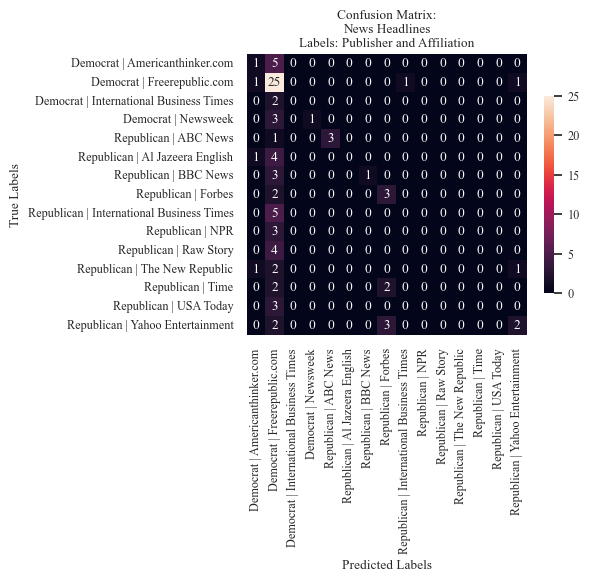

In [368]:
accuracy_news_data_combined, precision_news_data_combined, recall_news_data_combined = mnb_modeler(data_train_news_combined, labels_train_news_combined,
                                                                                         data_test_news_combined, labels_test_news_combinedr,
                                                                                          'LABEL',
                                                                                         'News Headlines',
                                                                                         'Publisher and Affiliation', 'mnb cm - news combined label.png',
                                                                                          True, 15, fig_x = 6, fig_y = 6)

### 3.2 Cliamte Related Bill Data

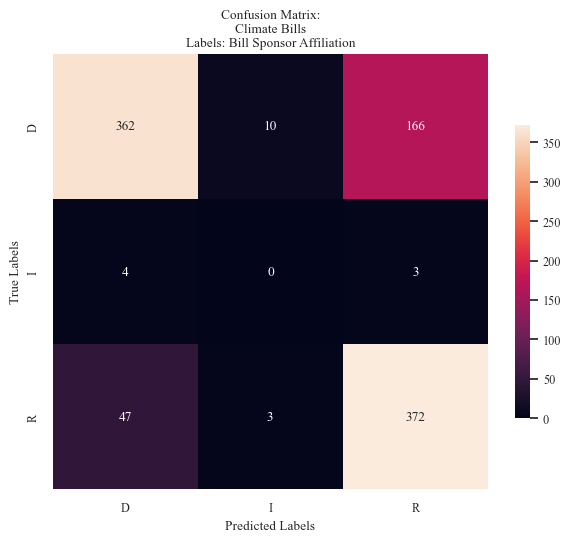

In [371]:
accuracy_bills_data_party, precision_bills_data_party, recall_bills_data_party = mnb_modeler(data_train_bills_party, labels_train_bills_party,
                                                                                         data_test_bills_party, labels_test_bills_party,
                                                                                          'Sponser Affiliation',
                                                                                         'Climate Bills',
                                                                                         'Bill Sponsor Affiliation', 'mnb cm - sponsor affiliation label.png',
                                                                                          False, 15, fig_x = 6, fig_y = 6)

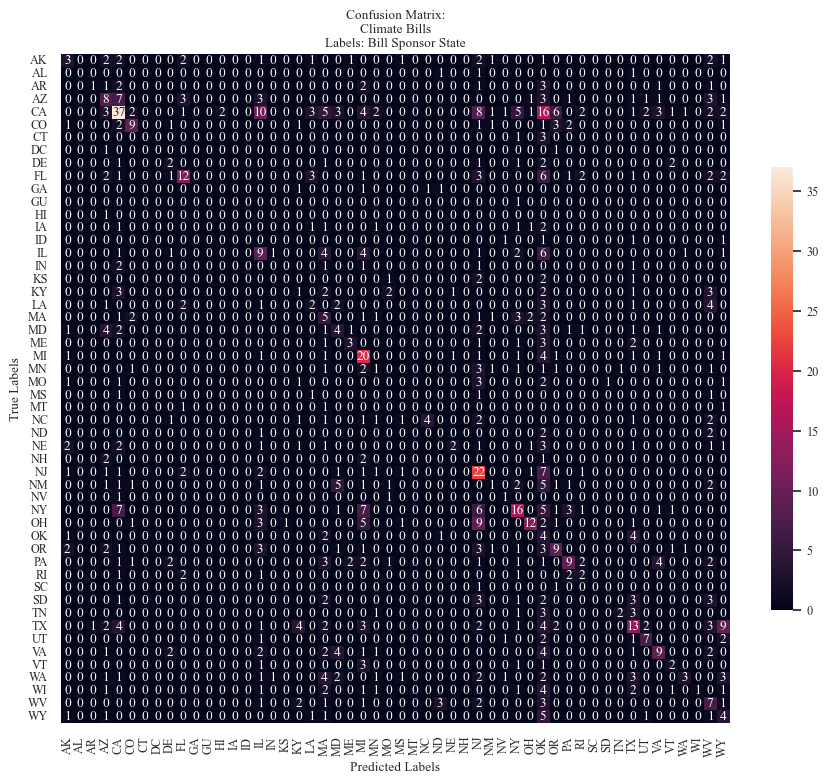

In [377]:
accuracy_bills_data_state, precision_bills_data_state, recall_bills_data_state = mnb_modeler(data_train_bills_state, labels_train_bills_state,
                                                                                         data_test_bills_state, labels_test_bills_state,
                                                                                          'Sponser State',
                                                                                         'Climate Bills',
                                                                                         'Bill Sponsor State', 'mnb cm - sponser state label.png',
                                                                                          False, 20, fig_x = 9, fig_y = 9)

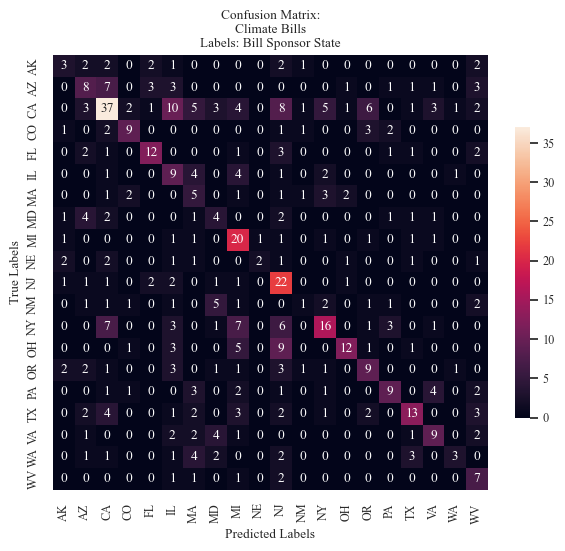

In [376]:
accuracy_bills_data_state, precision_bills_data_state, recall_bills_data_state = mnb_modeler(data_train_bills_state, labels_train_bills_state,
                                                                                         data_test_bills_state, labels_test_bills_state,
                                                                                          'Sponser State',
                                                                                         'Climate Bills',
                                                                                         'Bill Sponsor State', 'mnb cm - sponser state label truncated.png',
                                                                                          True, 20, fig_x = 6, fig_y = 6)

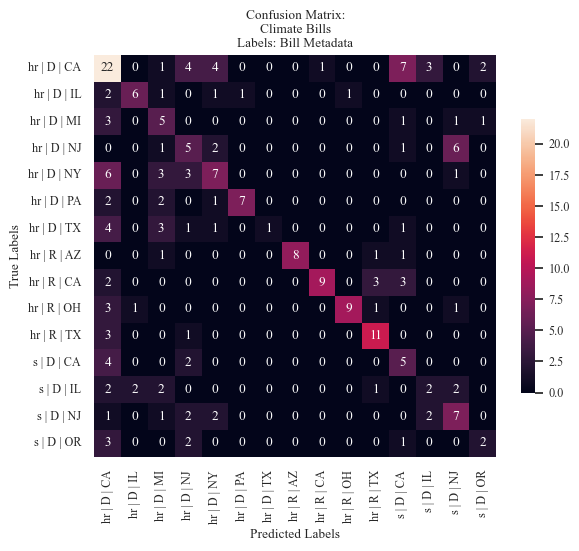

In [378]:
accuracy_bills_data_combined, precision_bills_data_combined, recall_bills_data_combined = mnb_modeler(data_train_bills_combined, labels_train_bills_combined,
                                                                                         data_test_bills_combined, labels_test_bills_combined,
                                                                                          'LABEL',
                                                                                         'Climate Bills',
                                                                                         'Bill Metadata', 'mnb cm - bill metadata label.png',
                                                                                          True, 15, fig_x = 6, fig_y = 6)

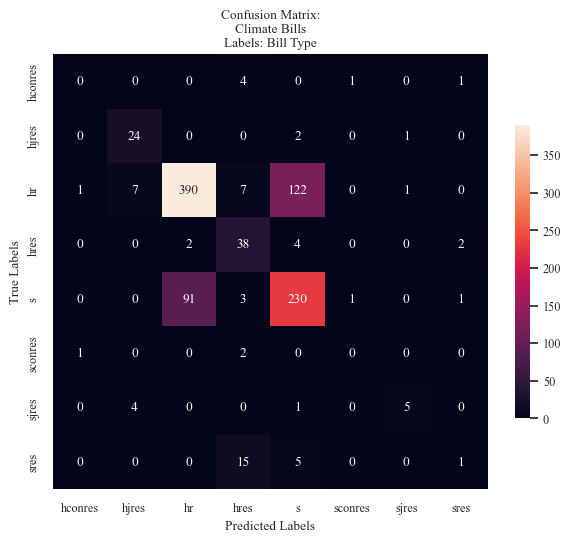

In [379]:
accuracy_bills_data_type, precision_bills_data_type, recall_bills_data_type = mnb_modeler(data_train_bills_type, labels_train_bills_type,
                                                                                         data_test_bills_type, labels_test_bills_type,
                                                                                          'Bill Type',
                                                                                         'Climate Bills',
                                                                                         'Bill Type', 'mnb cm - bill type label.png',
                                                                                          False, 15, fig_x = 6, fig_y = 6)

In [415]:
bill_data = [['hconres','Concurrent Resolution Originating From House of Representatives'],
             ['hjres','Joint Resolution Originating from House of Representatives'],
             ['hr','House of Representatives'],
             ['hres','Resolution From House of Representatives'],
             ['s','Senate'],
             ['sconres','Concurrent Resolution Originating From Senate'],
             ['sjres','Joint Resolution Originating from Senate'],
             ['sres','Resolution from Senate'],
            ]

        
headers = ['Abbreviation', ' Bill Type',]

bill_table = tabulate(bill_data, headers=headers, tablefmt='html',  stralign = 'left')

with open("Bill Types.html", "w") as file:
    file.write(bill_table)

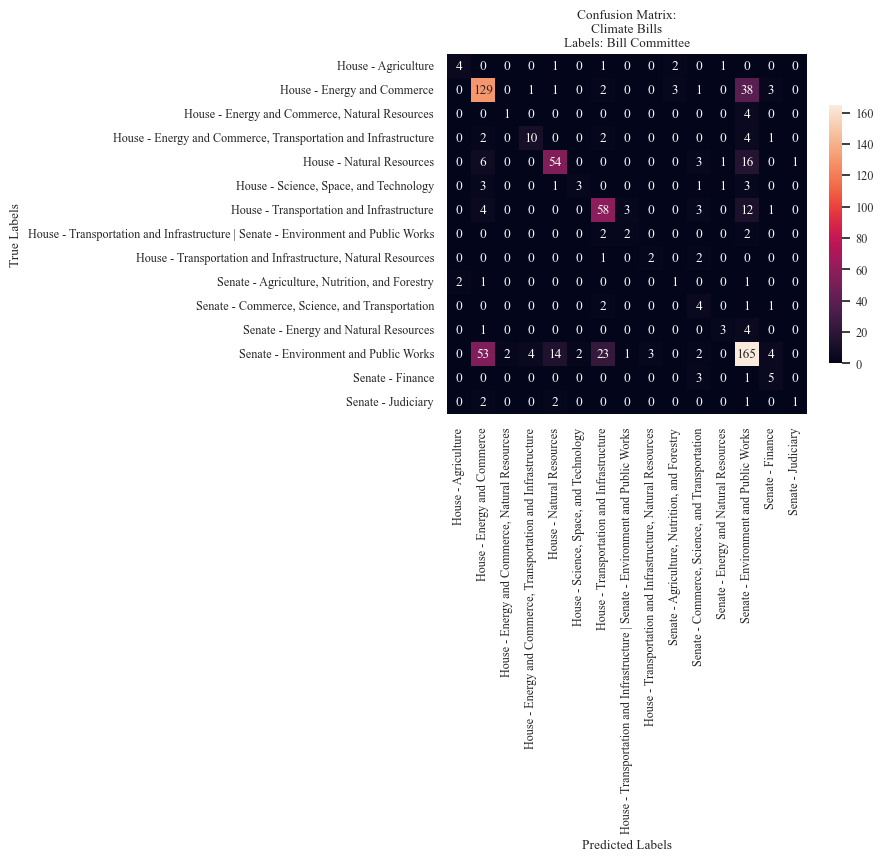

In [381]:
accuracy_bills_data_committee, precision_bills_data_committee, recall_bills_data_committee = mnb_modeler(data_train_bills_committee, labels_train_bills_committee,
                                                                                         data_test_bills_committee, labels_test_bills_committee,
                                                                                          'Committees',
                                                                                         'Climate Bills',
                                                                                         'Bill Committee', 'mnb cm - bill committee label.png',
                                                                                          True, 15, fig_x = 9, fig_y = 9)

## 4. Assessing Validity

In [382]:
data = [['News Headlines: Partisian Affiliation',accuracy_news_data_party, precision_news_data_party, recall_news_data_party],
['News Headlines: Publisher',accuracy_news_data_publisher, precision_news_data_publisher, recall_news_data_publisher],
['News Headlines: Publisher and Partisian Affiliation',accuracy_news_data_combined, precision_news_data_combined, recall_news_data_combined],
['Climate Bills: Sponsor Affiliation',accuracy_bills_data_party, precision_bills_data_party, recall_bills_data_party],
['Climate Bills: Sponsor State',accuracy_bills_data_state, precision_bills_data_state, recall_bills_data_state],
['Climate Bills: Metadata',accuracy_bills_data_combined, precision_bills_data_combined, recall_bills_data_combined],
['Climate Bills: Bill Type',accuracy_bills_data_type, precision_bills_data_type, recall_bills_data_type],
['Climate Bills: Hearing Committee',accuracy_bills_data_committee, precision_bills_data_committee, recall_bills_data_committee]]


for row in data:
    for i in range(1, 4):  # Loop over the columns with numeric data (index 1, 2, 3)
        row[i] = round(row[i], 3)
        
headers = ['', ' Accuracy', 'Precision', 'Recall']

table = tabulate(data, headers=headers, tablefmt='html', numalign='center', stralign = 'left')

with open("Model Evaluation.html", "w") as file:
    file.write(table)

In [383]:
table

,Accuracy,Precision,Recall
News Headlines: Partisian Affiliation,0.577,0.578,0.577
News Headlines: Publisher,0.276,0.16,0.145
News Headlines: Publisher and Partisian Affiliation,0.167,0.035,0.038
Climate Bills: Sponsor Affiliation,0.759,0.521,0.518
Climate Bills: Sponsor State,0.255,0.23,0.171
Climate Bills: Metadata,0.206,0.126,0.117
Climate Bills: Bill Type,0.711,0.449,0.463
Climate Bills: Hearing Committee,0.478,0.111,0.109


In [384]:
data = [['News Headlines:\n Partisian Affiliation',accuracy_news_data_party, precision_news_data_party, recall_news_data_party],
['News Headlines:\n Publisher',accuracy_news_data_publisher, precision_news_data_publisher, recall_news_data_publisher],
['News Headlines:\n Publisher and\nPartisian Affiliation',accuracy_news_data_combined, precision_news_data_combined, recall_news_data_combined],
['Climate Bills:\n Sponsor Affiliation',accuracy_bills_data_party, precision_bills_data_party, recall_bills_data_party],
['Climate Bills:\n Sponsor State',accuracy_bills_data_state, precision_bills_data_state, recall_bills_data_state],
['Climate Bills:\n Metadata',accuracy_bills_data_combined, precision_bills_data_combined, recall_bills_data_combined],
['Climate Bills:\n Bill Type',accuracy_bills_data_type, precision_bills_data_type, recall_bills_data_type],
['Climate Bills:\n Hearing Committee',accuracy_bills_data_committee, precision_bills_data_committee, recall_bills_data_committee]]


for row in data:
    for i in range(1, 4):  # Loop over the columns with numeric data (index 1, 2, 3)
        row[i] = round(row[i], 3)

model_eval = pd.DataFrame(data, columns=['Model','Accuracy','Precision','Recall'])

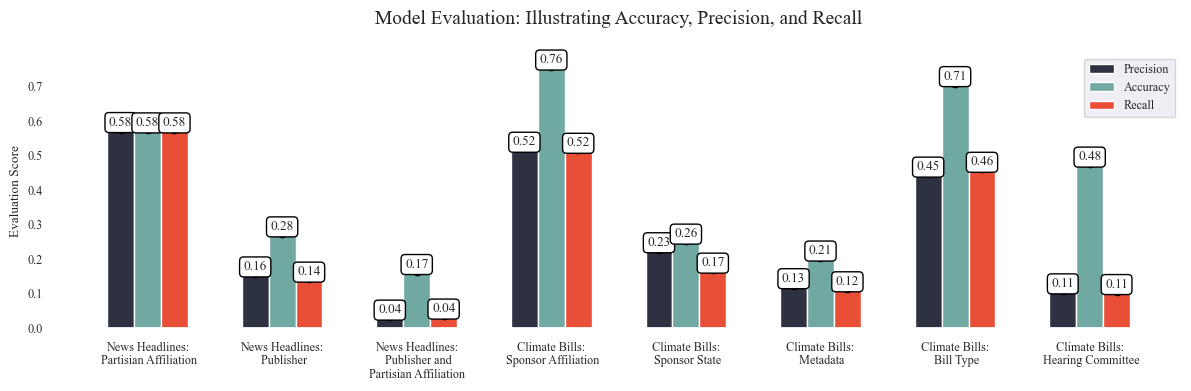

In [385]:

sb.set_style("white")
sb.set(font='Times New Roman', font_scale=0.8)
ax.set_facecolor('white')

models = model_eval['Model'].to_list()
precision = model_eval['Precision'].to_list()
accuracy = model_eval['Accuracy'].to_list()
recall = model_eval['Recall'].to_list()


fig, ax = plt.subplots(figsize=(12,4))
ax.set_facecolor('white')

# Width of the bars
bar_width = 0.2


index = np.arange(len(models))

# Plotting bars for Precision, Accuracy, and Recall
bar_precision = ax.bar(index - bar_width, precision, bar_width, label='Precision', color='#2d3142')
bar_accuracy = ax.bar(index, accuracy, bar_width, label='Accuracy', color='#70a9a1')
bar_recall = ax.bar(index + bar_width, recall, bar_width, label='Recall', color='#e94f37')

for bar_group in [bar_precision, bar_accuracy, bar_recall]:
    # Get heights and centers for each bar group
    heights = [bar.get_height() for bar in bar_group]
    centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_group]
    
    # Add markers (black dots) on top of the bars
    plt.scatter(centers, heights, color='black', zorder=3)

# Adding labels to the bars
for container in [bar_precision, bar_accuracy, bar_recall]:
    for bar in container:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', 
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

ax.set_title("Model Evaluation: Illustrating Accuracy, Precision, and Recall\n", fontsize=14)
ax.set_xlabel("")  
ax.set_ylabel("Evaluation Score")
ax.tick_params(axis='x')


ax.set_xticks(index)
ax.set_xticklabels(models)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(which='minor', linestyle=':', linewidth='0.5')  # Minor gridlines style
ax.grid(which='major', linestyle='-', linewidth='0.75')  # Major gridlines style


ax.legend()

plt.tight_layout()

plt.savefig("NB - Model Evaluation.png",dpi=1000)
plt.show();

## Graph Gallery

### Visualizing the top 10 News Publishers

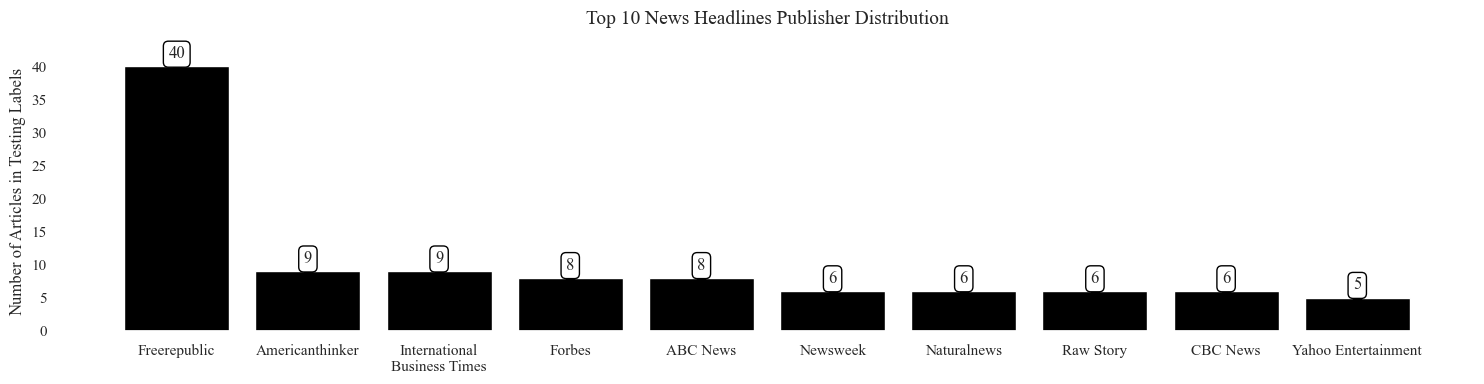

In [403]:
def remove_dotcom(x):
    clean = re.sub('\.com','',x)
    return (clean)

testing = pd.DataFrame(labels_test_news_publisher)
publisher_counts = pd.DataFrame(testing.value_counts()).reset_index().sort_values(by = 'count', ascending=False)
publisher_counts = publisher_counts.head(10)
publisher_counts['publisher'] = publisher_counts['publisher'].apply(lambda x: remove_dotcom(x))
publisher_counts = publisher_counts.replace('International Business Times', 'International\nBusiness Times')

sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1)
fig, ax = plt.subplots(figsize=(15, 4)) 
ax.set_facecolor('white')


hist = sb.barplot(
    data=publisher_counts,
    x='publisher',
    y = 'count',
   color='black',
    
    ax=ax
)

for bar_group in hist.containers:  # `containers` contains the histogram bars grouped by hue
    # Get heights and centers for each group
    heights = [bar.get_height() for bar in bar_group]
    centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_group]
    
    # Add markers
    plt.scatter(centers, heights, color='black', zorder=3)

for container in hist.containers:
    hist.bar_label(container, fmt='%d', label_type='edge', padding=3, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))



ax.set_title("Top 10 News Headlines Publisher Distribution\n",fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("Number of Articles in Testing Labels")
ax.tick_params(axis='x')

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))  
ax.grid(which='minor', linestyle=':', linewidth='0.5')  # Optional: style minor gridlines
ax.grid(which='major', linestyle='-', linewidth='0.75')  # Optional: style major gridlines

plt.tight_layout()

plt.savefig("NB - News Data Publisher Labels.png",dpi=1000)
plt.show();

### Visualizing the label distribution from the train test splits

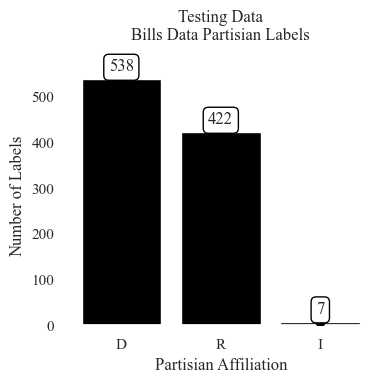

In [404]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1)
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.set_facecolor('white')


hist = sb.countplot(
    data=data_test_bills_party,
    x='Sponser Affiliation',
   color='black',
    
    ax=ax
)

for bar_group in hist.containers:  # `containers` contains the histogram bars grouped by hue
    # Get heights and centers for each group
    heights = [bar.get_height() for bar in bar_group]
    centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_group]
    
    # Add markers
    plt.scatter(centers, heights, color='black', zorder=3)

for container in hist.containers:
    hist.bar_label(container, fmt='%d', label_type='edge', padding=3, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))



ax.set_title("Testing Data\nBills Data Partisian Labels\n")
ax.set_xlabel("Partisian Affiliation")
ax.set_ylabel("Number of Labels")
ax.tick_params(axis='x')

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))  
ax.grid(which='minor', linestyle=':', linewidth='0.5')  # Optional: style minor gridlines
ax.grid(which='major', linestyle='-', linewidth='0.75')  # Optional: style major gridlines

plt.tight_layout()

plt.savefig("NB - Testing Data - Party Data Partisan Labels.png",dpi=1000)
plt.show();

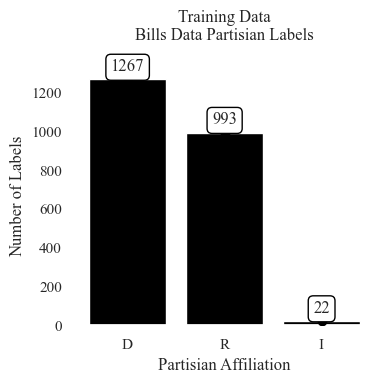

In [94]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1)
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.set_facecolor('white')


hist = sb.countplot(
    data=data_train_bills_party,
    x='Sponser Affiliation',
   color='black',
    
    ax=ax
)

for bar_group in hist.containers:  # `containers` contains the histogram bars grouped by hue
    # Get heights and centers for each group
    heights = [bar.get_height() for bar in bar_group]
    centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_group]
    
    # Add markers
    plt.scatter(centers, heights, color='black', zorder=3)

for container in hist.containers:
    hist.bar_label(container, fmt='%d', label_type='edge', padding=3, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))



ax.set_title("Training Data\nBills Data Partisian Labels\n")
ax.set_xlabel("Partisian Affiliation")
ax.set_ylabel("Number of Labels")
ax.tick_params(axis='x')

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))  
ax.grid(which='minor', linestyle=':', linewidth='0.5')  # Optional: style minor gridlines
ax.grid(which='major', linestyle='-', linewidth='0.75')  # Optional: style major gridlines

plt.tight_layout()

plt.savefig("NB - Training Data - Bills Data Partisan Labels.png",dpi=1000)
plt.show();

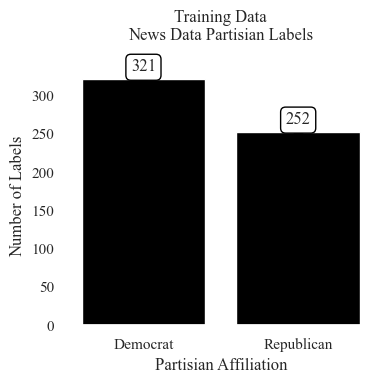

In [405]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1)
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.set_facecolor('white')


hist = sb.countplot(
    data=data_train_news_party,
    x='Party',
   color='black',
    
    ax=ax
)

for bar_group in hist.containers:  # `containers` contains the histogram bars grouped by hue
    # Get heights and centers for each group
    heights = [bar.get_height() for bar in bar_group]
    centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_group]
    
    # Add markers
    plt.scatter(centers, heights, color='black', zorder=3)

for container in hist.containers:
    hist.bar_label(container, fmt='%d', label_type='edge', padding=3, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))



ax.set_title("Training Data\nNews Data Partisian Labels\n")
ax.set_xlabel("Partisian Affiliation")
ax.set_ylabel("Number of Labels")
ax.tick_params(axis='x')

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))  
ax.grid(which='minor', linestyle=':', linewidth='0.5')  # Optional: style minor gridlines
ax.grid(which='major', linestyle='-', linewidth='0.75')  # Optional: style major gridlines

plt.tight_layout()

plt.savefig("NB - Training Data - News Data Partisan Labels.png",dpi=1000)
plt.show();

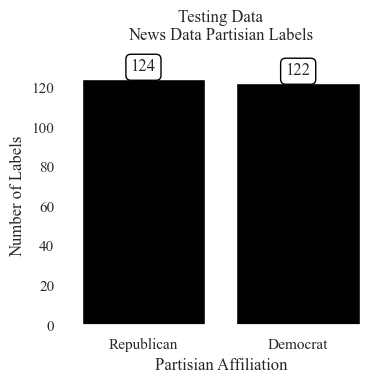

In [406]:
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=1)
fig, ax = plt.subplots(figsize=(4, 4)) 
ax.set_facecolor('white')


hist = sb.countplot(
    data=data_test_news_party,
    x='Party',
   color='black',
    
    ax=ax
)

for bar_group in hist.containers:  # `containers` contains the histogram bars grouped by hue
    # Get heights and centers for each group
    heights = [bar.get_height() for bar in bar_group]
    centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_group]
    
    # Add markers
    plt.scatter(centers, heights, color='black', zorder=3)

for container in hist.containers:
    hist.bar_label(container, fmt='%d', label_type='edge', padding=3, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))



ax.set_title("Testing Data\nNews Data Partisian Labels\n")
ax.set_xlabel("Partisian Affiliation")
ax.set_ylabel("Number of Labels")
ax.tick_params(axis='x')

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))  
ax.grid(which='minor', linestyle=':', linewidth='0.5')  # Optional: style minor gridlines
ax.grid(which='major', linestyle='-', linewidth='0.75')  # Optional: style major gridlines

plt.tight_layout()

plt.savefig("NB - Testing Data - News Data Partisan Labels.png",dpi=1000)
plt.show();